In [2]:
from rdkit import Chem
import pubchempy as pcp
from pubchempy import get_compounds
from rdkit.Chem import Draw
import pandas as pd
import re
import sys
import traceback
import xml.etree.ElementTree as ET
from typing import Optional
import pandas as pd
import requests

from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True


In [5]:
#function that gets the smile for each molecule
def get_test(compound):
    results = pcp.get_compounds(compound, 'name')
    for compound in results:
        smiles= compound.isomeric_smiles
        mol=Chem.MolFromSmiles(smiles)
        return mol
#function that allows all molecules to be represented at the same time

[Compound(2244)]

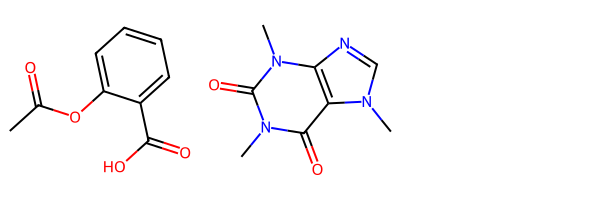

In [13]:

def generate_image(list:list):
    mss=[]
    for index,value in enumerate(list):
        mss.append(get_test(value))
    return Draw.MolsToGridImage(mss)

generate_image(["aspirin","caffeine"])


In [8]:
#We need an entry in Cas or the name but need to specify it in the second entry of the function
# either pka_lookup_pubchem("acetic acid", "Name") or pka_lookup_pubchem("'64-19-7' ","cid")


debug = False


def pka_lookup_pubchem(identifier, namespace=None, domain='compound') -> Optional[str]:
    global debug

    if len(sys.argv) == 2 and sys.argv[1] in ['--debug=True', '--debug=true', '--debug', '-d']:
        debug = True

    # if debug:
    #     print(f'In DEBUG mode: {debug}')

    # Identify lookup source (Pubchem in this case)
    lookup_source = 'Pubchem'

    try:
        headers = {
            'user-agent': 'Mozilla/5.0 (X11; CentOS; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.75 Safari/537.36'}
        # Using pubchem api for python
        # Getting CID number, the result of this, by default is exact match. The result is returned as a list.
        cids = []
        identifier_type = ''

        if not namespace:
            identifier_type = classify(identifier)

            # If the input is inchi, inchikey or smiles (this could be a false smiles):
            if identifier_type in ['smiles', 'inchi', 'inchikey']:
                lookup = pcp.get_cids(identifier, namespace=identifier_type)
                if lookup:
                    cids.append(lookup[0])
            else:
                lookup = pcp.get_cids(identifier, namespace='name')
                if lookup:
                    cids.append(lookup[0])
                    # print(f'namespace from pubchem lookup is: {namespace}')
        elif namespace == 'cas':
            cids = pcp.get_cids(identifier, namespace='name')
        else:
            cids = pcp.get_cids(identifier, namespace=namespace)

        if not cids:
            lookup = pcp.get_cids(identifier, namespace='name')
            if lookup:
                cids.append(lookup[0])

            # cids = pcp.get_cids(identifier, namespace=namespace)
            identifier_type = namespace

        if len(cids) > 0:
            # if Pubchem found the result, get the first result of the list
            cid = cids[0]

            exact_match = True

            # synonyms = []
            synonyms = pcp.get_synonyms(cid)[0]['Synonym'] or []
            
            # Extract CAS number from the list of synonyms
            returned_cas = ''
            for synonym in synonyms:
                cas_nr = re.search(r'^\d{2,7}-\d{2}-\d$', synonym)
                if cas_nr:
                    cas_nr = cas_nr.group()
                    returned_cas = cas_nr
                    break

            lookup_result = pcp.get_properties(['inchi', 'inchikey',
                                        'canonical_smiles', 'isomeric_smiles',
                                        'iupac_name'],
                                cid)

            if identifier_type == 'cas':
                # To double check if the CAS number is correct:
                # using pubchem api, get a list of synonym. The result is a list of dict.
                # choose the first result and check all values for 'Synonym' key:
                exact_match = identifier in synonyms

            elif identifier_type in ['inchi', 'inchikey']:

                if identifier_type == 'inchi':
                    # print(lookup_result[0].get('InChI', False))
                    # print(f'input:\n{identifier}')
                    exact_match = (identifier == lookup_result[0].get('InChI', False))
                
                elif identifier_type == 'inchikey':
                    exact_match = (identifier == lookup_result[0].get('InChIKey', False))

            if not exact_match:
                if debug:
                    print(f'Exact match between input and Pubchem return value? {identifier in synonyms}')
                raise ValueError('This is not an exact match on Pubchem!')


            pka_lookup_result_xml = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/{}/XML?heading=Dissociation+Constants'.format(cid)

            # Get the html request info using CID number from pubchem
            r = requests.get(pka_lookup_result_xml, headers=headers, timeout=15)
            # Check to see if give OK status (200) and not redirect
            if r.status_code == 200 and len(r.history) == 0:
                # print(r.text)
                # Use python XML to parse the return result
                tree = ET.fromstring(r.text)
            
                # Get the XML tree of  only
                info_node = tree.find('.//*{http://pubchem.ncbi.nlm.nih.gov/pug_view}Information')

                # Get the pKa reference:
                original_source = info_node.find('{http://pubchem.ncbi.nlm.nih.gov/pug_view}Reference').text
                # Get the pKa result:
                pka_result = info_node.find('.//*{http://pubchem.ncbi.nlm.nih.gov/pug_view}String').text
                pka_result = re.sub(r'^pKa = ', '', pka_result)    # remove 'pka = ' part out of the string answer
                # print(pka_result)
                # print(original_source)
                # print(lookup_result)

                core_result = {
                    'source': lookup_source,
                    'Pubchem_CID': str(cid),
                    'pKa': pka_result,
                    'reference': original_source,
                    'Substance_CASRN': returned_cas,
                }
                extra_info = lookup_result[0]
                extra_info.pop('CID', None)    # Remove 'CID': ... from lookup_result[0]

                # Merge 2 dict: https://treyhunner.com/2016/02/how-to-merge-dictionaries-in-python/
                result = {**core_result, **extra_info}
                # Rename some keys in the dict
                s = pd.Series(result)
                s = s.rename({
                    'CanonicalSMILES': 'Canonical_SMILES',
                    'IsomericSMILES': 'Isomeric_SMILES',
                    'IUPACName': 'IUPAC_Name'
                })
                result = s.to_dict()            
                return result

            else:
                raise RuntimeError('pKa not found in Pubchem.')
    
        else:
            raise RuntimeError('Compound not found in Pubchem.')

    except Exception as error:
        if debug:
            traceback_str = ''.join(traceback.format_exception(etype=type(error), value=error, tb=error.__traceback__))
            print(traceback_str)

        return None

In [9]:
def pka_increasing(list):
    dict={}
    for i in range (len(list)):
        pka=pka_lookup_pubchem(list[i],'name')
        dict[pka['pKa'][0:3]]=list[i]
    print (sorted(dict.items()))

In [10]:
def main():
        #get the number of molecule in int form
    while True:
        number_molecule = input("How many molecules: ")
        try:
            number_molecule = int(number_molecule)
            break  
        except ValueError:
            print("Invalid syntax, please enter an integer number")
        #get the molecule name and put it in a list
        
    list_of_molecule = []

    for i in range(number_molecule):
        while True:
            name_i=input(f"Molecule name {i+1}:")
            try:
                res=pcp.get_compounds(name_i, "name")
                mol = res[0].isomeric_smiles
                if mol is None:
                    raise ValueError("Unable to generate the molecular formula.")
                list_of_molecule.append((name_i))
                break
            except ValueError:
                print("Value error, please try again with the correct name")
                
    generate_image(list_of_molecule)
    pka_increasing(list_of_molecule)


In [11]:
if __name__ == "__main__":
   main()

[('14', 'caffeine'), ('3.4', 'aspirin'), ('4.7', 'acetic acid')]
